In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap

In [5]:
import os

os.chdir('/content/drive/MyDrive/')

In [6]:
os.chdir('/content/drive/MyDrive/gi-tract-image-segmentation/datasets')

In [8]:
import os
import shutil

directory_path = '/content/drive/MyDrive/gi-tract-image-segmentation/datasets'

# Loop through each item in the specified directory
for item in os.listdir(directory_path):
    print(item)
    item_path = os.path.join(directory_path, item)  # Construct full path

    # Check if it's a directory
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)  # Remove the directory and all its contents
        print(f"Deleted directory: {item_path}")
    else:
        os.remove(item_path)  # Remove the file
        print(f"Deleted file: {item_path}")

sample_submission.csv
Deleted file: /content/drive/MyDrive/gi-tract-image-segmentation/datasets/sample_submission.csv
train.csv
Deleted file: /content/drive/MyDrive/gi-tract-image-segmentation/datasets/train.csv
train
Deleted directory: /content/drive/MyDrive/gi-tract-image-segmentation/datasets/train


In [9]:
import zipfile
import os

zip_path = '/content/drive/My Drive/srikaran/uw-madison-gi-tract-image-segmentation.zip'
extract_path = '/content/drive/My Drive/gi-tract-image-segmentation/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


In [10]:
import zipfile
import os

zip_path = '/content/drive/My Drive/srikaran/coco.zip'
extract_path = '/content/drive/My Drive/gi-tract-image-segmentation/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


In [11]:
# !unzip "/content/drive/My Drive/uw-madison-gi-tract-image-segmentation.zip" -d "/content/drive/My Drive/gi-tract-image-segmentation/datasets/"

In [12]:
!ls train/case90/case90_day0/scans

slice_0001_266_266_1.50_1.50.png  slice_0073_266_266_1.50_1.50.png
slice_0002_266_266_1.50_1.50.png  slice_0074_266_266_1.50_1.50.png
slice_0003_266_266_1.50_1.50.png  slice_0075_266_266_1.50_1.50.png
slice_0004_266_266_1.50_1.50.png  slice_0076_266_266_1.50_1.50.png
slice_0005_266_266_1.50_1.50.png  slice_0077_266_266_1.50_1.50.png
slice_0006_266_266_1.50_1.50.png  slice_0078_266_266_1.50_1.50.png
slice_0007_266_266_1.50_1.50.png  slice_0079_266_266_1.50_1.50.png
slice_0008_266_266_1.50_1.50.png  slice_0080_266_266_1.50_1.50.png
slice_0009_266_266_1.50_1.50.png  slice_0081_266_266_1.50_1.50.png
slice_0010_266_266_1.50_1.50.png  slice_0082_266_266_1.50_1.50.png
slice_0011_266_266_1.50_1.50.png  slice_0083_266_266_1.50_1.50.png
slice_0012_266_266_1.50_1.50.png  slice_0084_266_266_1.50_1.50.png
slice_0013_266_266_1.50_1.50.png  slice_0085_266_266_1.50_1.50.png
slice_0014_266_266_1.50_1.50.png  slice_0086_266_266_1.50_1.50.png
slice_0015_266_266_1.50_1.50.png  slice_0087_266_266_1.50_1.50

In [13]:
os.chdir('/content/drive/MyDrive/gi-tract-image-segmentation')

In [14]:
from src.data import SegmentationDataset
from src.data import DataGenerator

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [15]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1 - dice

def dice_coef_func(y_true, y_pred, smooth=1):
    y_true_f = y_true.contiguous().view(-1)
    y_pred_f = y_pred.contiguous().view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

In [16]:
# url = 'https://www.dropbox.com/scl/fi/cfmbvq2bj99wpx3sdorhp/train_json.json?rlkey=nltq4tgaflkkl6jx8a3jnlg01&dl=0'

# !wget -O "/content/drive/My Drive/gi-tract-image-segmentation/datasets/train.json" "https://www.dropbox.com/scl/fi/cfmbvq2bj99wpx3sdorhp/train_json.json?rlkey=nltq4tgaflkkl6jx8a3jnlg01&dl=0"


In [17]:
# url = "https://www.dropbox.com/scl/fi/bzz4xta6t8b4wkma3td4l/val_json.json?rlkey=r0tsvzwjowqz9389tu6tv0fi1&dl=0"

# !wget -O "/content/drive/My Drive/gi-tract-image-segmentation/datasets/val.json" "https://www.dropbox.com/scl/fi/bzz4xta6t8b4wkma3td4l/val_json.json?rlkey=r0tsvzwjowqz9389tu6tv0fi1&dl=0"

In [18]:
# url = "https://www.dropbox.com/scl/fi/p8kovus5wy1r04n6suehl/test_json.json?rlkey=mz4wv0vl41veiow2y5k1kd511&dl=0"

# !wget -O "/content/drive/My Drive/gi-tract-image-segmentation/datasets/test.json" "https://www.dropbox.com/scl/fi/p8kovus5wy1r04n6suehl/test_json.json?rlkey=mz4wv0vl41veiow2y5k1kd511&dl=0"

In [19]:
train_generator_class = DataGenerator(dataset_dir='/content/drive/MyDrive/gi-tract-image-segmentation/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/drive/MyDrive/gi-tract-image-segmentation/datasets/coco/train_json.json',
                                     shuffle=True)

val_generator_class = DataGenerator(dataset_dir='/content/drive/MyDrive/gi-tract-image-segmentation/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/drive/MyDrive/gi-tract-image-segmentation/datasets/coco/val_json.json',
                                     shuffle=True)

test_generator_class = DataGenerator(dataset_dir='/content/drive/MyDrive/gi-tract-image-segmentation/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/drive/MyDrive/gi-tract-image-segmentation/datasets/coco/test_json.json',
                                     shuffle=False)

loading annotations into memory...
Done (t=1.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [20]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_masks(X, y):
    # Create custom colormaps for the masks
    cmap1 = ListedColormap(['none', 'red'])  # Mask 1 in red
    cmap2 = ListedColormap(['none', 'green'])  # Mask 2 in green
    cmap3 = ListedColormap(['none', 'blue'])  # Mask 3 in blue

    fig, ax = plt.subplots()
    # Display the grayscale image
    ax.imshow((X/255.)[:,:,0], cmap='gray')

    # Display the first mask
    ax.imshow(y[:,:,0], cmap=cmap1, alpha=0.5)

    # Display the second mask
    ax.imshow(y[:,:,1], cmap=cmap2, alpha=0.5)

    # Display the third mask
    ax.imshow(y[:,:,2], cmap=cmap3, alpha=0.5)

    # Create a legend for the masks
    red_patch = mpatches.Patch(color='red', label='Small Bowel')
    green_patch = mpatches.Patch(color='green', label='Large Bowel')
    blue_patch = mpatches.Patch(color='blue', label='Stomach')
    plt.legend(handles=[red_patch, green_patch, blue_patch])

    # Show the plot
    plt.show()

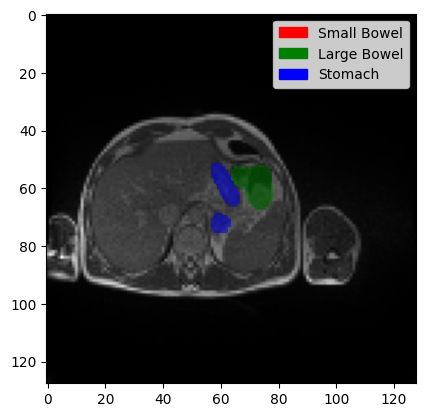

In [21]:
# Assuming X and y are loaded as mentioned
X, y = train_generator_class.__getitem__(0)

plot_masks(X, y)

In [22]:
train_loader = DataLoader(train_generator_class, batch_size=32, num_workers=0)
val_loader = DataLoader(val_generator_class, batch_size=32, num_workers=0)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

In [23]:
print("Batch size:", train_loader.batch_size)
print("Num workers:", train_loader.num_workers)
print("Dataset size:", len(train_loader.dataset))
print("Number of batches:", len(train_loader))

Batch size: 32
Num workers: 0
Dataset size: 14269
Number of batches: 446


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [25]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.InstanceNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(0.1)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.InstanceNorm2d(out_channels)
        self.relu2 = nn.LeakyReLU(0.1)
        self._init_weights()

    def forward(self, x):
        x = self.relu1(self.norm1(self.conv1(x)))
        x = self.relu2(self.norm2(self.conv2(x)))
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
        self._init_weights()

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

    def _init_weights(self):
        # Initialize weights for the transpose convolution
        nn.init.kaiming_normal_(self.up.weight, mode='fan_out', nonlinearity='relu')
        if self.up.bias is not None:
            nn.init.constant_(self.up.bias, 0)

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.inc = ConvBlock(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.outc = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        self._init_weights()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return self.sigmoid(logits)

    def _init_weights(self):
        # Initialize weights for the final output convolution
        nn.init.kaiming_normal_(self.outc.weight, mode='fan_out', nonlinearity='relu')
        if self.outc.bias is not None:
            nn.init.constant_(self.outc.bias, 0)


In [26]:
model = SimpleUNet()
input = torch.randn(1, 3, 128, 128)  # Example input
output = model(input)
print(output.shape)  # Should be torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])


In [27]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleUNet().to(device)

# Optimizer and Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

# Loss function
criterion = DiceLoss().to(device)

# Training and validation loops
train_losses = []
val_losses = []
train_dice_coefs = []
val_dice_coefs = []
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss_meter = AverageMeter()
    dice_coef_meter = AverageMeter()

    for data, target in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item(), data.size(0))
        dice_coef_meter.update(dice_coef_func(output, target).item(), data.size(0))

    train_losses.append(train_loss_meter.avg)
    train_dice_coefs.append(dice_coef_meter.avg)

    # Validation phase
    model.eval()
    val_loss_meter = AverageMeter()
    val_dice_coef_meter = AverageMeter()

    with torch.no_grad():
        for data, target in tqdm(val_loader, desc=f'Epoch {epoch} Validation'):
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 3, 1, 2)
            target = target.permute(0, 3, 1, 2)
            output = model(data)
            loss = criterion(output, target)

            val_loss_meter.update(loss.item(), data.size(0))
            val_dice_coef_meter.update(dice_coef_func(output, target).item(), data.size(0))

    val_losses.append(val_loss_meter.avg)
    val_dice_coefs.append(val_dice_coef_meter.avg)

    scheduler.step(val_loss_meter.avg)
    print(f'Epoch {epoch}: Train Loss: {train_loss_meter.avg:.4f}, Val Loss: {val_loss_meter.avg:.4f}, Train Dice: {dice_coef_meter.avg:.4f}, Val Dice: {val_dice_coef_meter.avg:.4f}')

    # Save model checkpoint
    torch.save(model.state_dict(), f'UNET_model_epoch_{epoch}.pth')


Using device: cuda


Epoch 0 Validation: 100%|██████████| 145/145 [00:36<00:00,  3.93it/s]


Epoch 0: Train Loss: 0.3576, Val Loss: 0.3427, Train Dice: 0.6424, Val Dice: 0.6573


Epoch 1 Validation: 100%|██████████| 145/145 [00:36<00:00,  3.93it/s]


Epoch 1: Train Loss: 0.1239, Val Loss: 0.2625, Train Dice: 0.8761, Val Dice: 0.7375


Epoch 2 Validation: 100%|██████████| 145/145 [00:36<00:00,  3.97it/s]


Epoch 2: Train Loss: 0.0772, Val Loss: 0.2286, Train Dice: 0.9228, Val Dice: 0.7714


Epoch 3 Validation: 100%|██████████| 145/145 [00:36<00:00,  3.94it/s]


Epoch 3: Train Loss: 0.0513, Val Loss: 0.2262, Train Dice: 0.9487, Val Dice: 0.7738


Epoch 4 Validation: 100%|██████████| 145/145 [00:36<00:00,  3.93it/s]


Epoch 4: Train Loss: 0.0350, Val Loss: 0.1939, Train Dice: 0.9650, Val Dice: 0.8061


Epoch 5 Validation: 100%|██████████| 145/145 [00:37<00:00,  3.89it/s]


Epoch 5: Train Loss: 0.0233, Val Loss: 0.1880, Train Dice: 0.9767, Val Dice: 0.8120


Epoch 6 Validation: 100%|██████████| 145/145 [00:36<00:00,  3.96it/s]


Epoch 6: Train Loss: 0.0162, Val Loss: 0.1830, Train Dice: 0.9838, Val Dice: 0.8170


Epoch 7 Validation: 100%|██████████| 145/145 [00:36<00:00,  3.96it/s]


Epoch 7: Train Loss: 0.0046, Val Loss: 0.1885, Train Dice: 0.9954, Val Dice: 0.8115


Epoch 8 Validation: 100%|██████████| 145/145 [00:37<00:00,  3.87it/s]


Epoch 8: Train Loss: 0.0002, Val Loss: 0.1966, Train Dice: 0.9998, Val Dice: 0.8034


Epoch 9 Validation: 100%|██████████| 145/145 [00:36<00:00,  3.92it/s]


Epoch 9: Train Loss: -0.0057, Val Loss: 0.1891, Train Dice: 1.0057, Val Dice: 0.8109


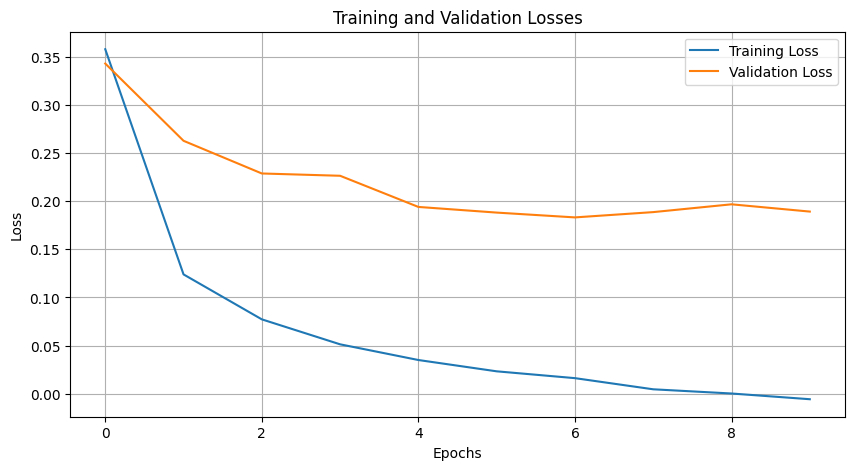

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

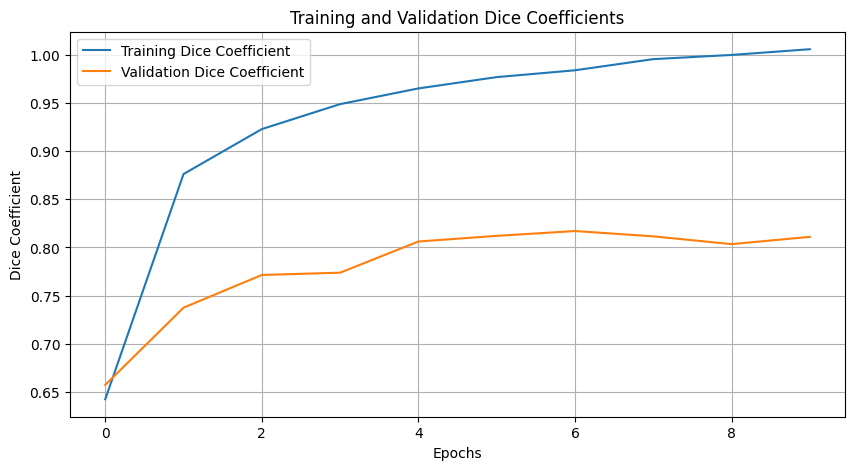

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(train_dice_coefs, label='Training Dice Coefficient')
plt.plot(val_dice_coefs, label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficients')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()


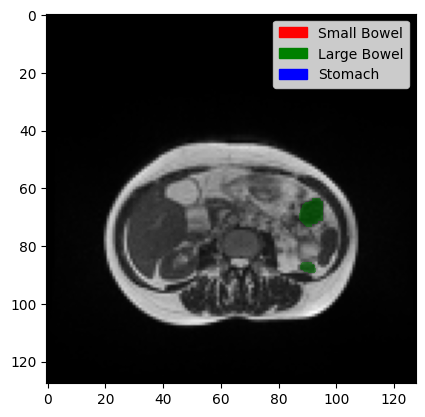

In [31]:
from matplotlib.colors import ListedColormap

X, y = test_generator_class.__getitem__(9)

plot_masks(X, y)

In [32]:
model

SimpleUNet(
  (inc): ConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): LeakyReLU(negative_slope=0.1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu2): LeakyReLU(negative_slope=0.1)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu1): LeakyReLU(negative_slope=0.1)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): InstanceNorm2d(128, eps=1e-05, m

In [35]:
images_test = []
predictions = []
masks = []
# No need to track gradients here
with torch.no_grad():
    for data in test_loader:
        # Assuming your DataLoader returns a tuple of (images, labels)
        images = data[0]
        images = images.permute(0, 3, 1, 2).to(device)
        images_test.append(images)
        print(images.shape)
        # Generate predictions
        output = model(images).permute(0, 2, 3, 1)
        predictions.append(output)
        masks.append(data[1])

torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size

In [36]:
img_s = images_test[0].permute(0, 2, 3, 1)
pred_s = predictions[0]
mask_s = masks[0]

In [37]:
mask_s.shape, pred_s.shape

(torch.Size([32, 128, 128, 3]), torch.Size([32, 128, 128, 3]))

In [40]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np  # Ensure NumPy is imported

def plot_masks(X, y, title=""):
    # Move tensors to CPU and convert to NumPy arrays
    X = X.cpu().numpy() if X.is_cuda else X.numpy()
    y = y.cpu().numpy() if y.is_cuda else y.numpy()

    # Create custom colormaps for the masks
    cmap1 = ListedColormap(['none', 'red'])  # Mask 1 in red
    cmap2 = ListedColormap(['none', 'green'])  # Mask 2 in green
    cmap3 = ListedColormap(['none', 'blue'])  # Mask 3 in blue

    fig, ax = plt.subplots()
    # Display the grayscale image
    ax.imshow(X[:,:,0], cmap='gray')  # Assuming the image is already normalized

    # Display the first mask
    ax.imshow(y[:,:,0], cmap=cmap1, alpha=0.5)

    # Display the second mask
    ax.imshow(y[:,:,1], cmap=cmap2, alpha=0.5)

    # Display the third mask
    ax.imshow(y[:,:,2], cmap=cmap3, alpha=0.5)

    # Create a legend for the masks
    red_patch = mpatches.Patch(color='red', label='Small Bowel')
    green_patch = mpatches.Patch(color='green', label='Large Bowel')
    blue_patch = mpatches.Patch(color='blue', label='Stomach')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    plt.title(title)
    plt.show()


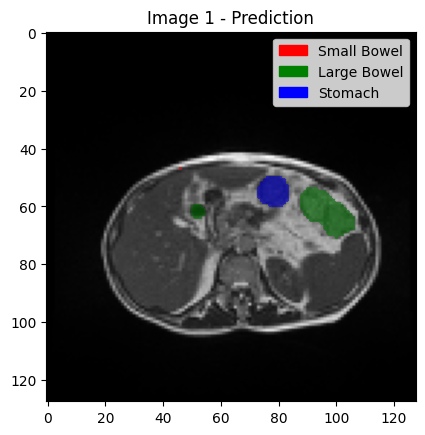

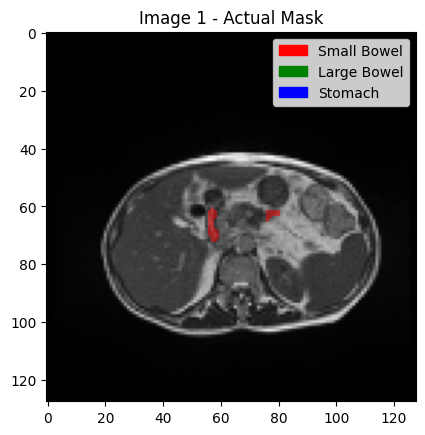

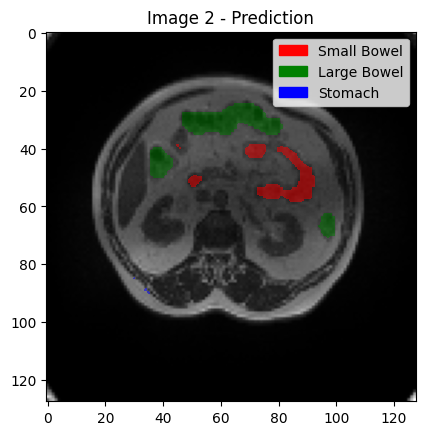

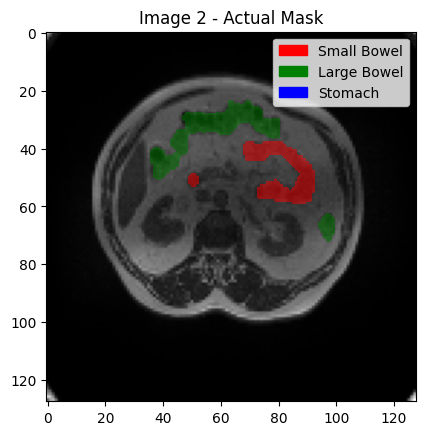

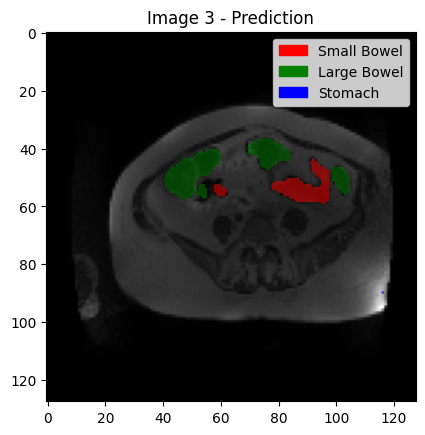

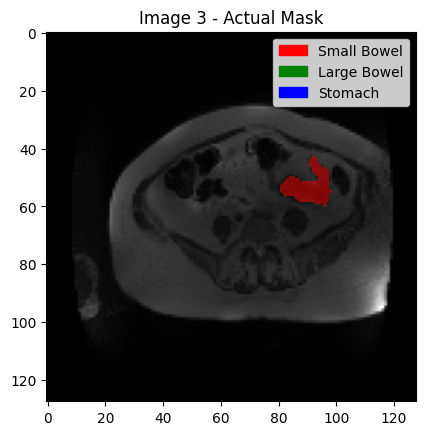

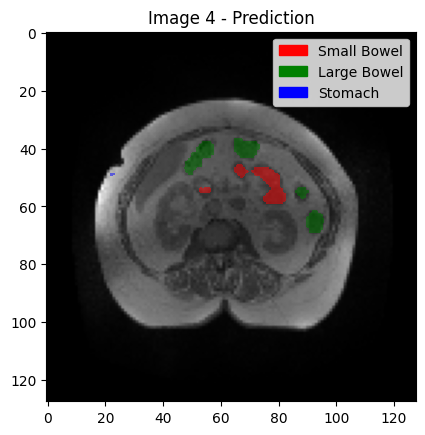

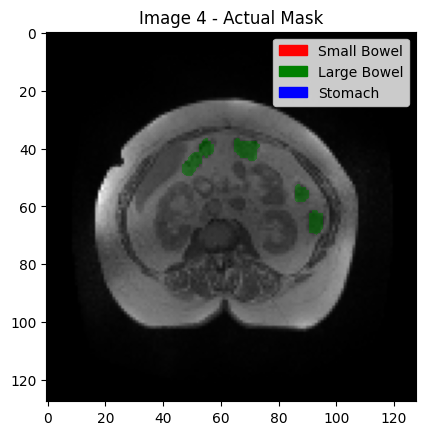

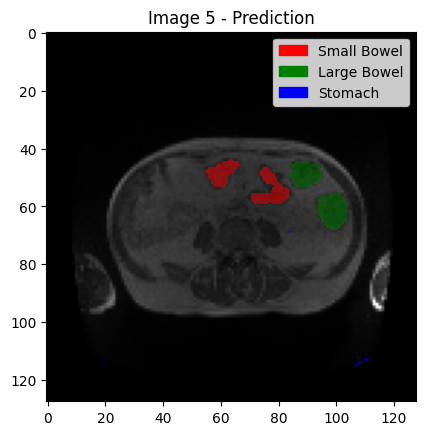

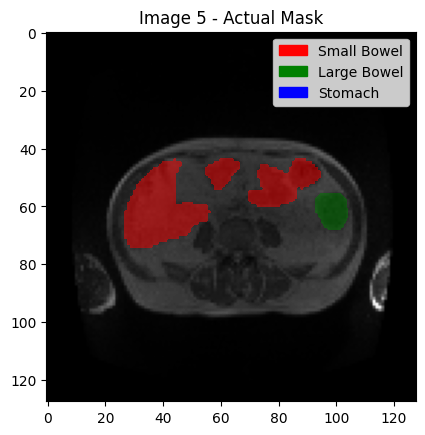

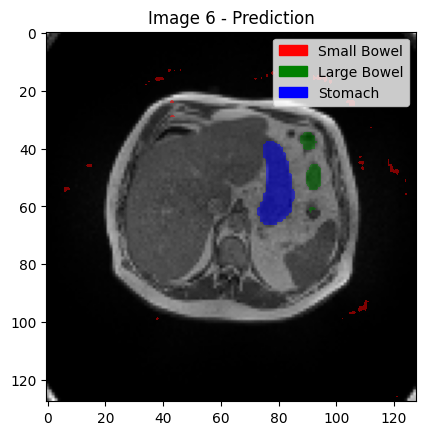

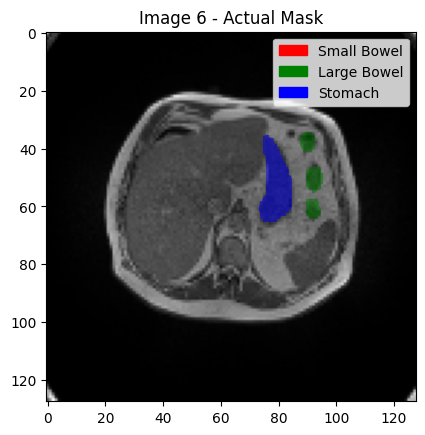

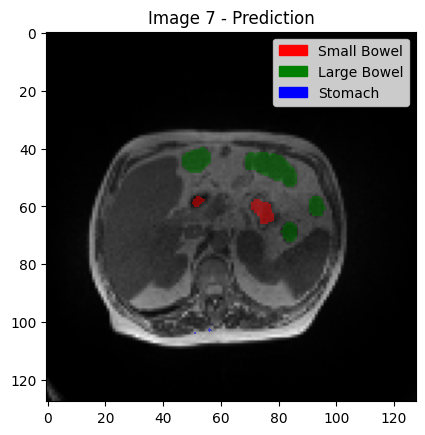

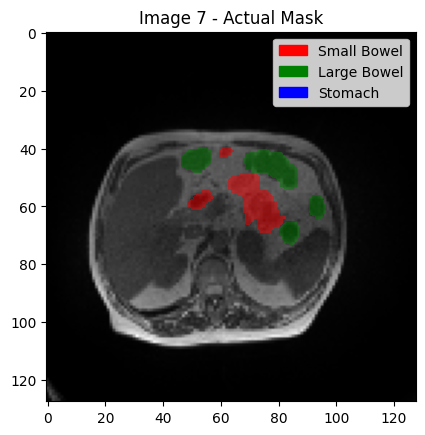

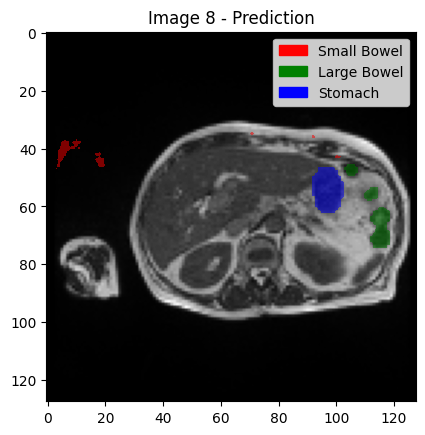

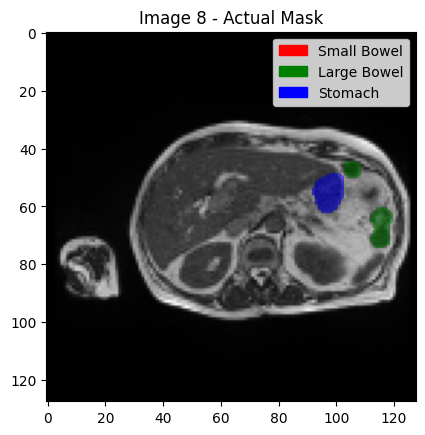

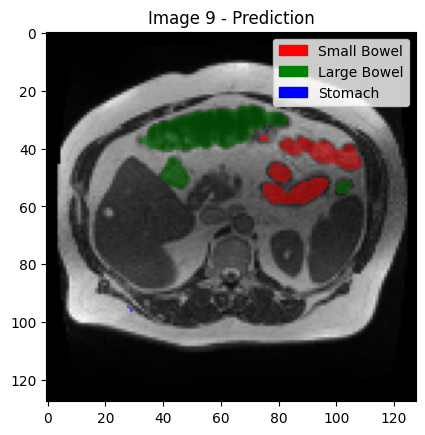

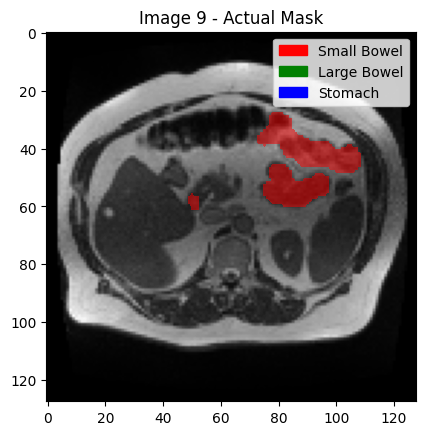

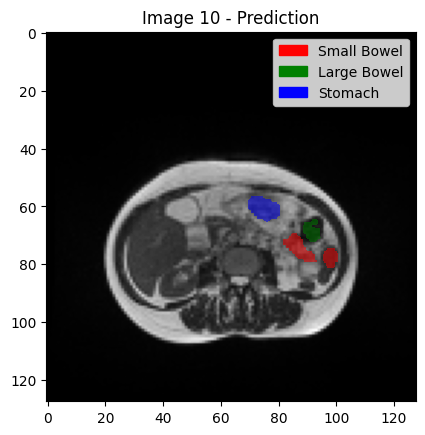

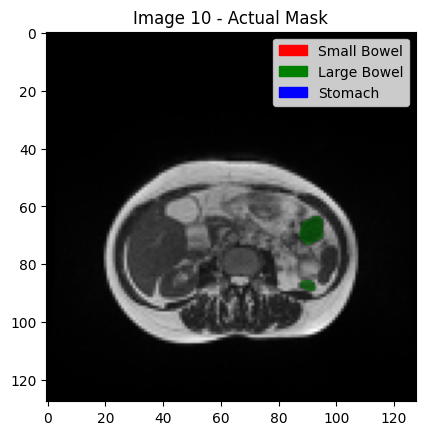

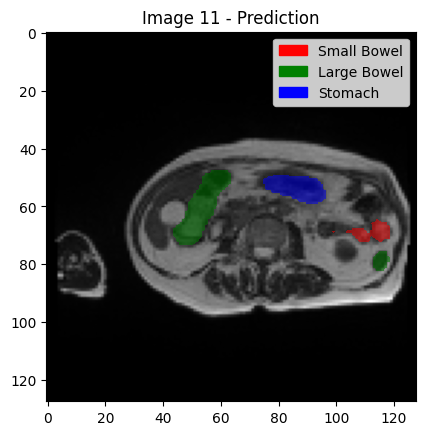

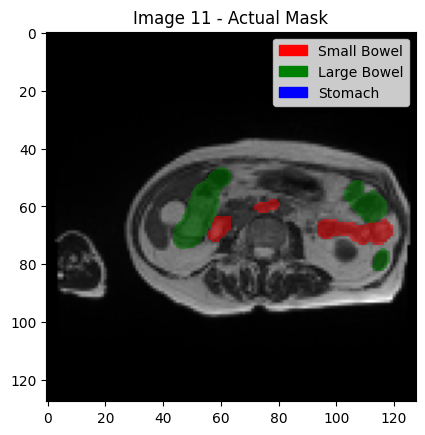

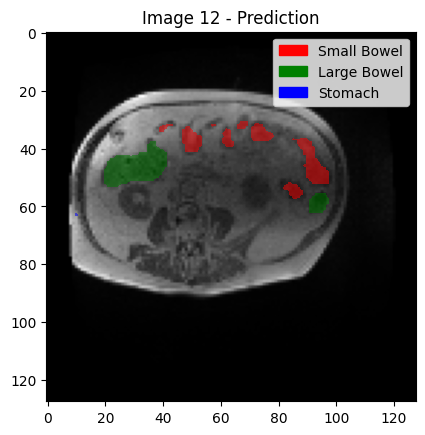

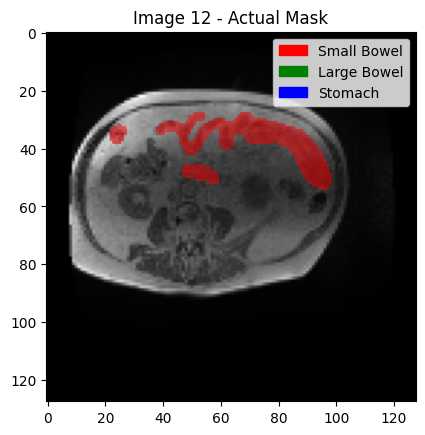

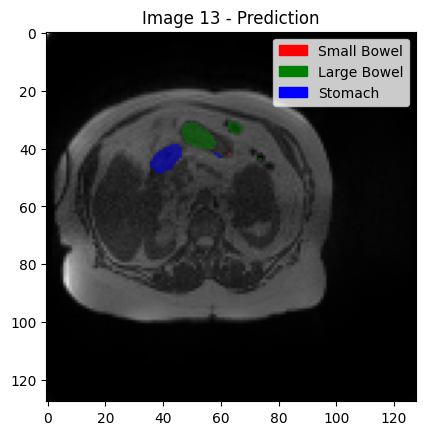

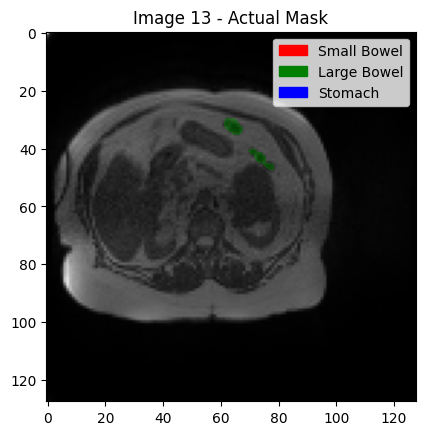

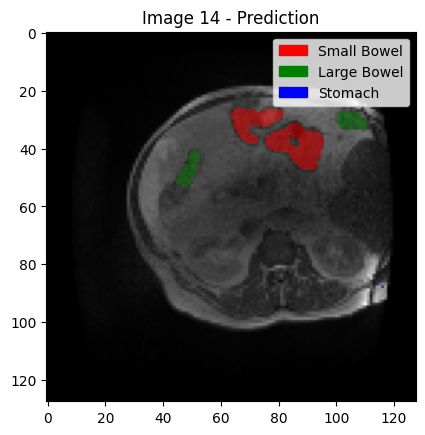

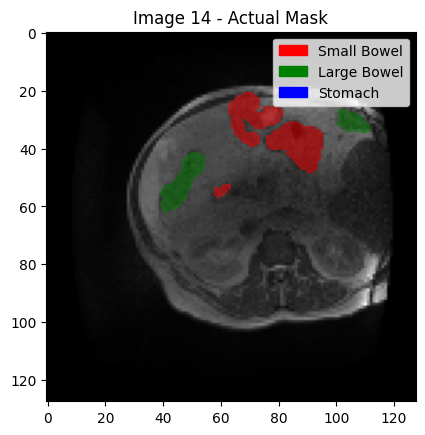

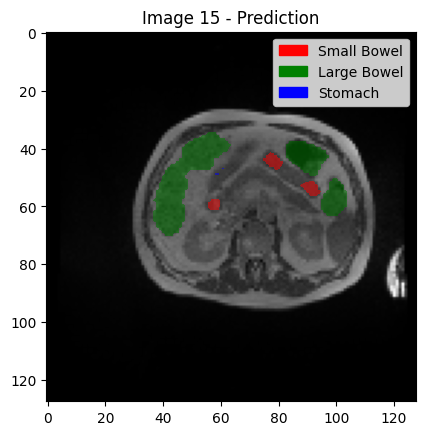

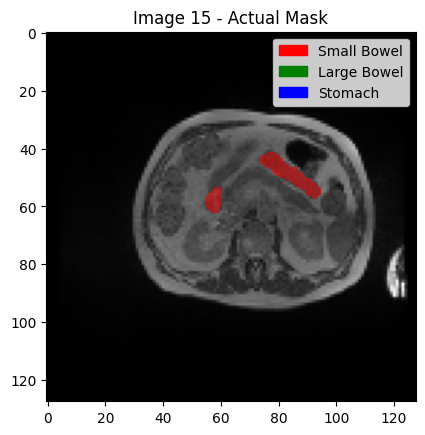

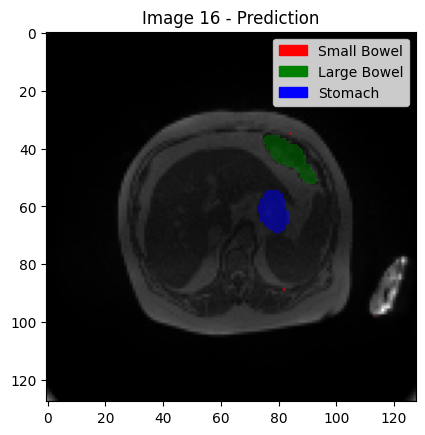

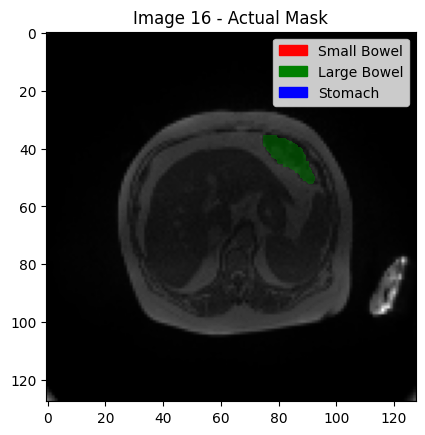

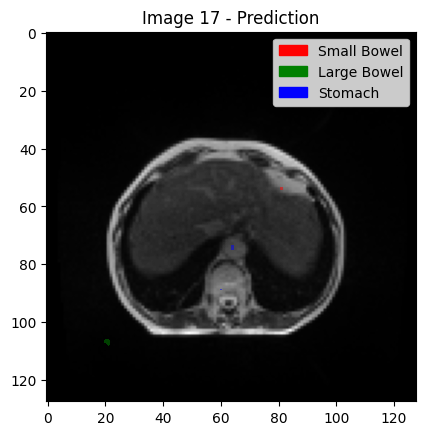

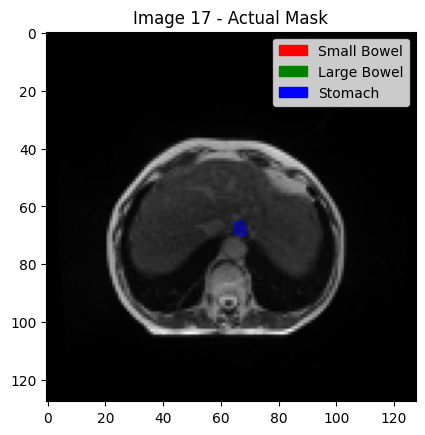

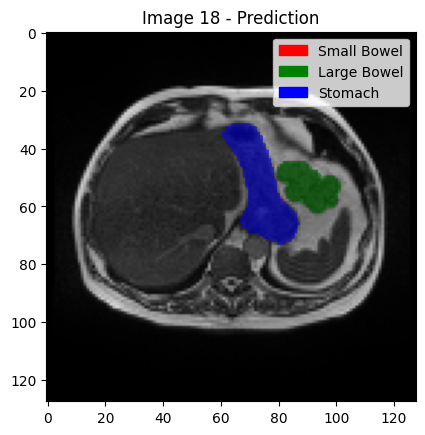

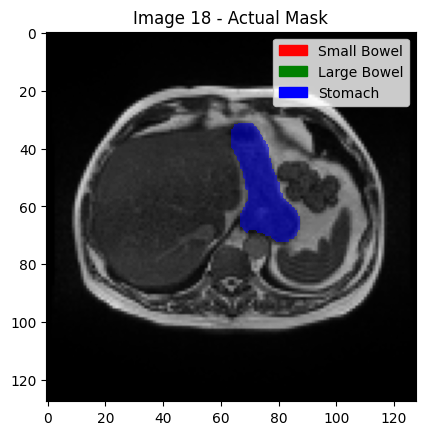

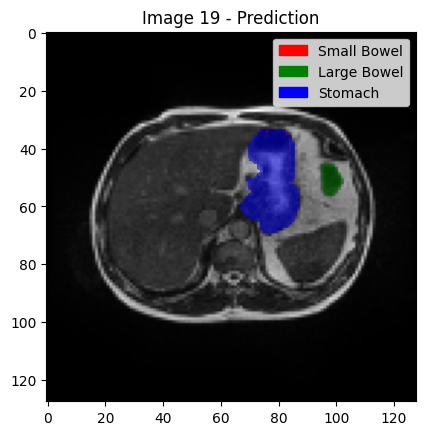

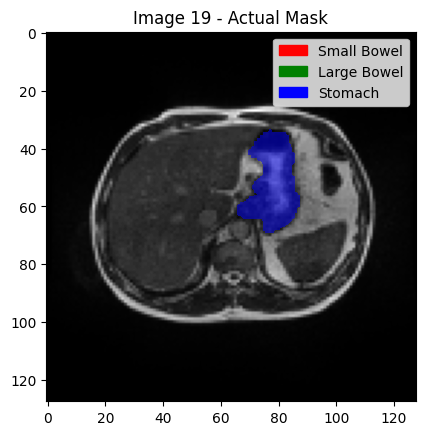

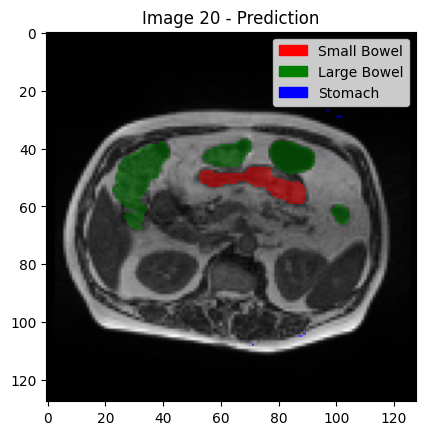

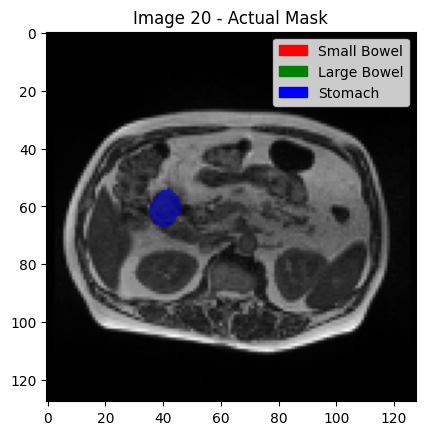

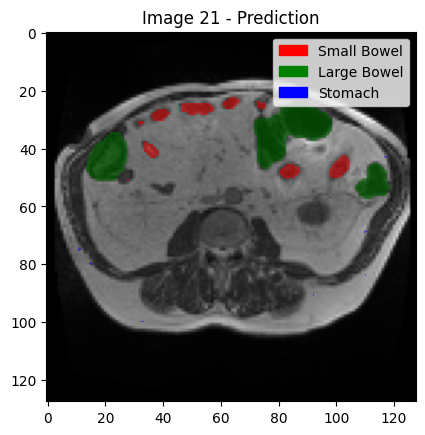

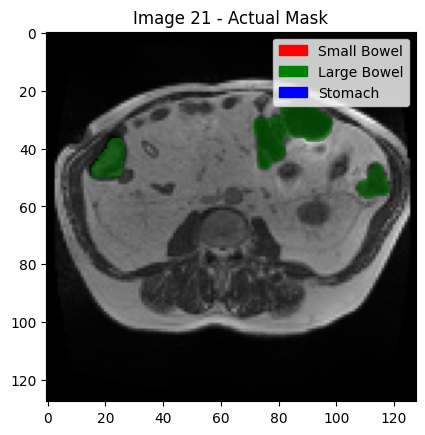

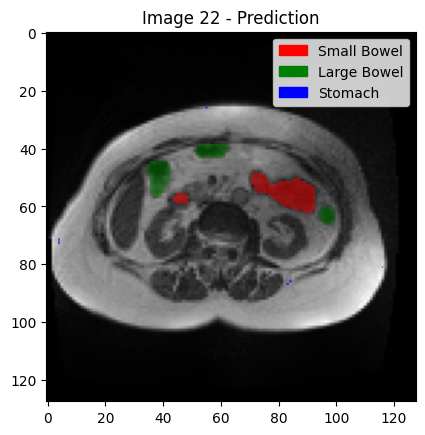

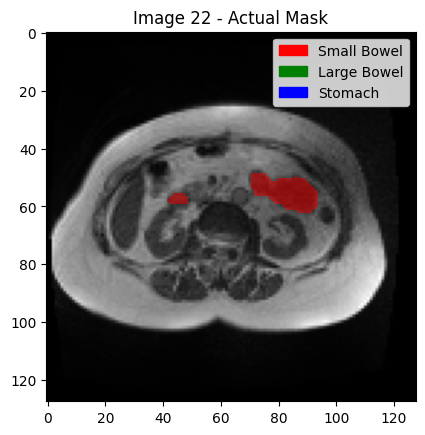

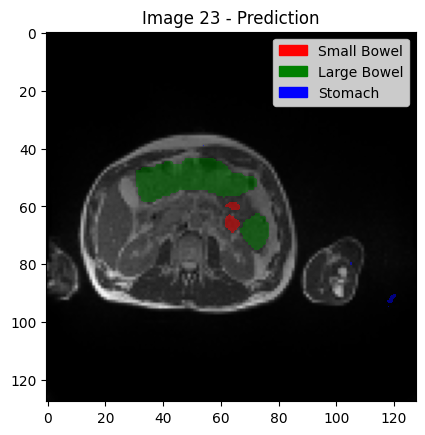

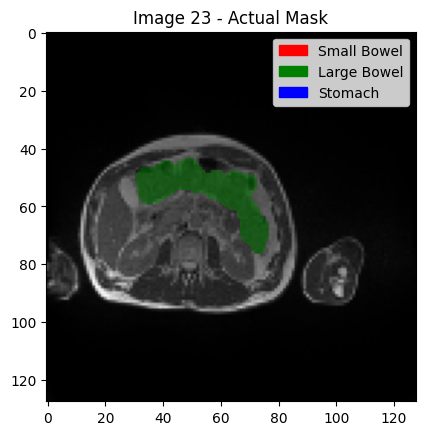

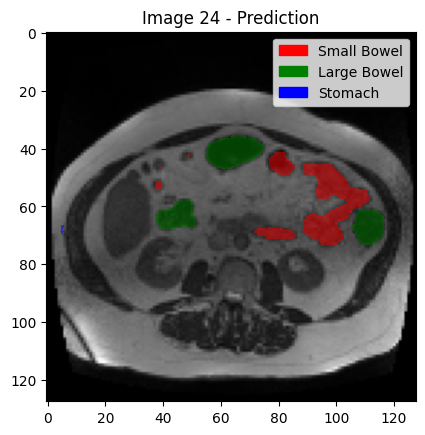

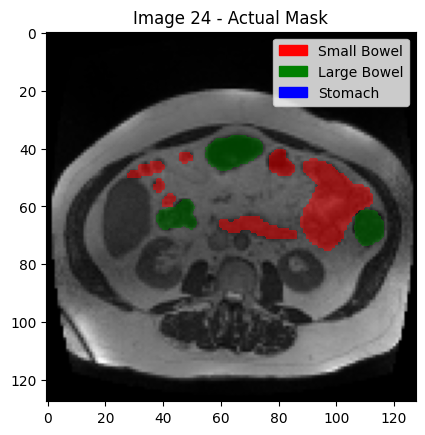

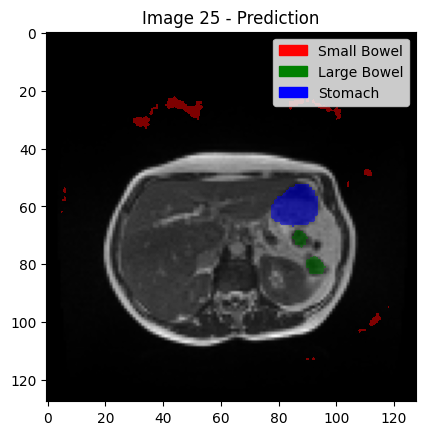

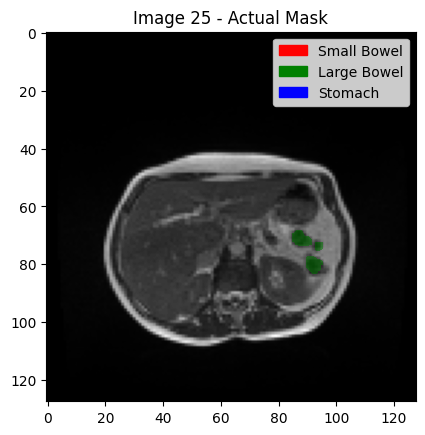

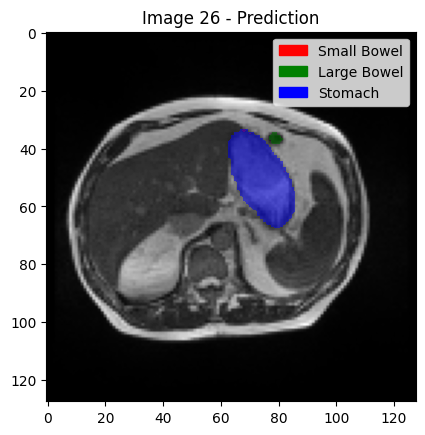

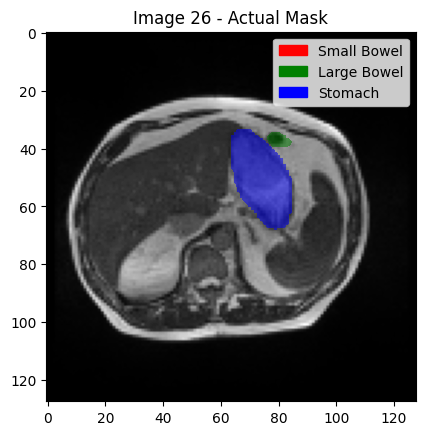

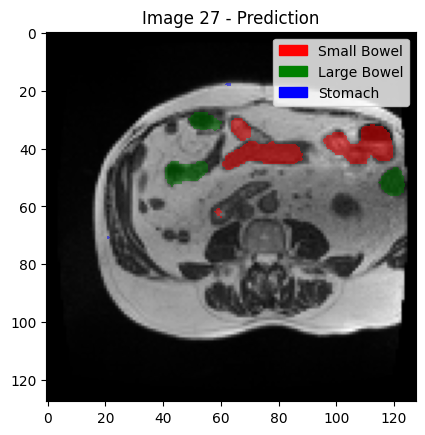

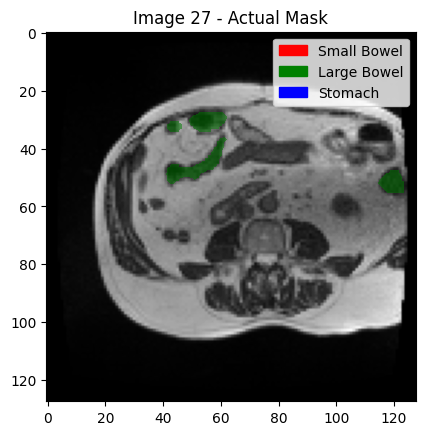

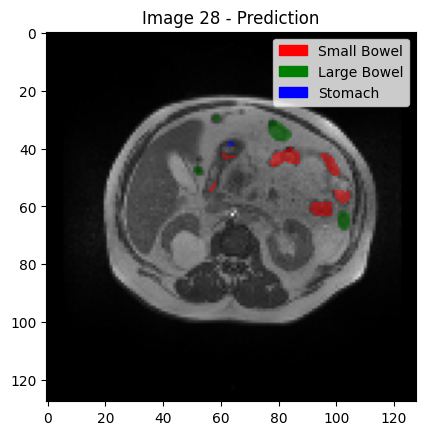

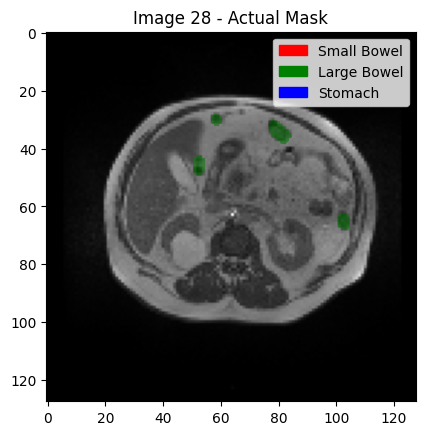

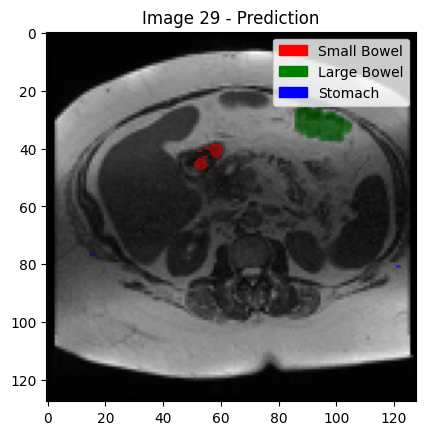

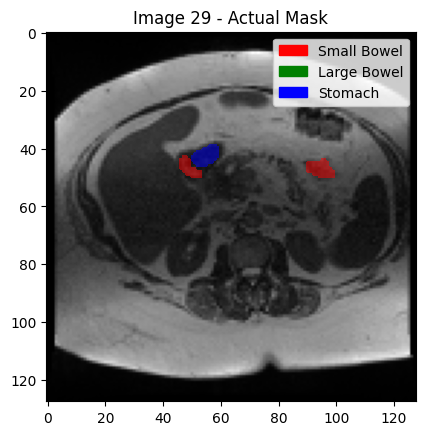

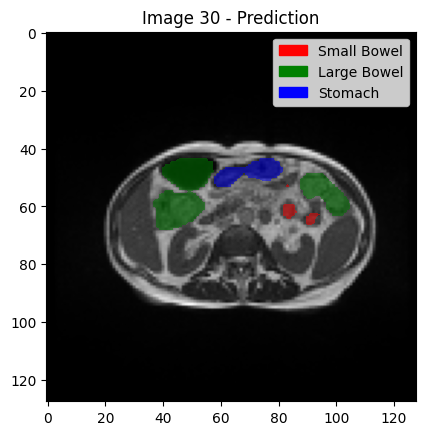

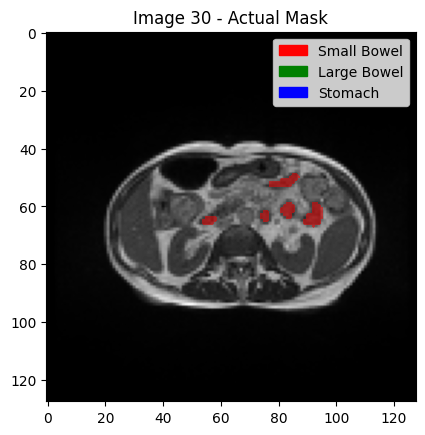

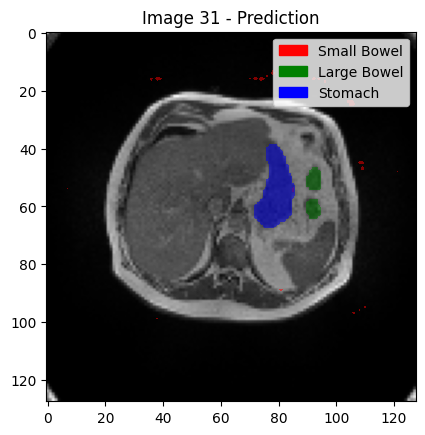

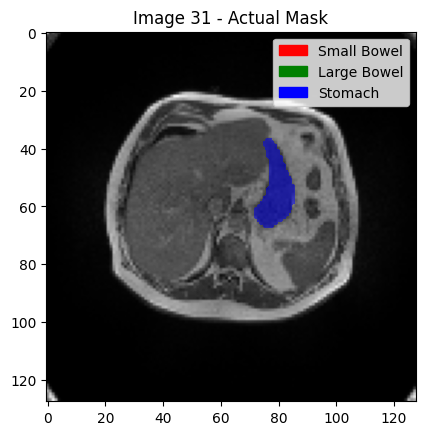

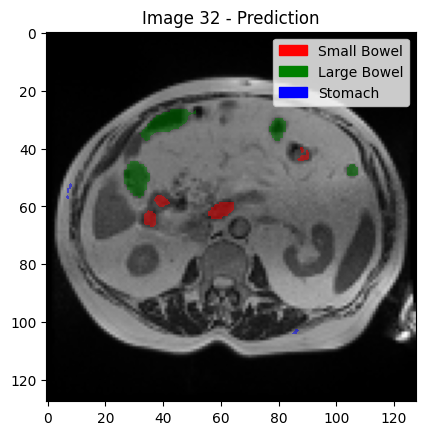

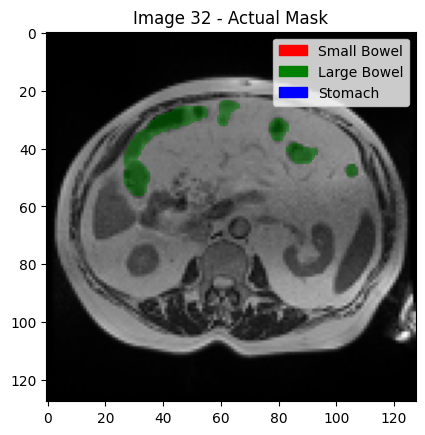

In [41]:
for i in range(len(img_s)):  # Loop through each of the 32 images
    plot_masks(img_s[i], pred_s[i], title=f"Image {i+1} - Prediction")
    plot_masks(img_s[i], mask_s[i], title=f"Image {i+1} - Actual Mask")

In [28]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

# Making the most of your colab subscription



## Faster GPUs

<p>Users who have purchased one of Colab's paid plans have access to premium GPUs. You can upgrade your notebook's GPU settings in <code>Runtime &gt; Change runtime type</code> in the menu to enable Premium accelerator. Subject to availability, selecting a premium GPU may grant you access to a V100 or A100 Nvidia GPU.</p>
<p>The free-of-charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.</p>

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is 'Not connected to a GPU', you can change the runtime by going to <code>Runtime &gt; Change runtime type</code> in the menu to enable a GPU accelerator, and then re-execute the code cell.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May  8 09:56:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In order to use a GPU with your notebook, select the <code>Runtime &gt; Change runtime type</code> menu, and then set the hardware accelerator drop-down to GPU.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available.
You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is 'Not using a high-RAM runtime', then you can enable a high-RAM runtime via <code>Runtime &gt; Change runtime type</code> in the menu. Then select High-RAM in the Runtime shape drop-down. After, re-execute the code cell.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time &#40;which is faster if the runtime isn't executing code&#41;. Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.


## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.

If you encounter limitations, you can relax those limitations by purchasing more compute units via pay as you go. Anyone can purchase compute units via <a href="https://colab.research.google.com/signup">pay as you go</a>; no subscription is required.

## Send us feedback!

<p>If you have any feedback for us, please let us know. The best way to send feedback is by using the Help &gt; 'Send feedback…' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.</p>
<p>If you encounter errors or other issues with billing &#40;payments&#41; for Colab Pro, Pro+ or pay as you go, please email <a href="mailto:colab-billing@google.com">colab-billing@google.com</a>.</p>

## More resources

### Working with notebooks in Colab
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with data
- [Loading data: Drive, Sheets and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualising data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine learning crash course
These are a few of the notebooks from Google's online machine learning course. See the <a href="https://developers.google.com/machine-learning/crash-course/">full course website</a> for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using accelerated hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine learning examples

To see end-to-end examples of the interactive machine-learning analyses that Colaboratory makes possible, take a look at these tutorials using models from <a href="https://tfhub.dev">TensorFlow Hub</a>.

A few featured examples:

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Retraining an Image Classifier</a>: Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Text Classification</a>: Classify IMDB film reviews as either <em>positive</em> or <em>negative</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Style Transfer</a>: Use deep learning to transfer style between images.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>: Use a machine-learning model to answer questions from the SQuAD dataset.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Video Interpolation</a>: Predict what happened in a video between the first and the last frame.
